# Notebook 2: Data cleaning and structuring, and Logistic Regression

### Libraries used for all notebooks 

In [59]:
# Import libaries
import requests
from bs4 import BeautifulSoup
import pandas as pd
from scrapy.selector import Selector
from scrapy.http import HtmlResponse
import re
import time
from sklearn.model_selection import train_test_split
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
import matplotlib.pyplot as plt
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud
from sklearn.metrics import confusion_matrix

In [60]:
!pip install wordcloud

### Importing CSV files
Previously exported CSV files in Notebook 1 are imported in to perform cleaning

In [61]:
#importing CSV files 
rships = pd.read_csv("../datasets/rships.csv", index_col = 'Unnamed: 0')
jnm = pd.read_csv("../datasets/jnm.csv", index_col = 'Unnamed: 0')

### Setting up the combined dataframes

The dataframes for the separate reddit data were set up so that they can be easily combined. 
Steps:

1. Text columns were renamed to 'posts'

2. Subreddit were numbered 0 for r/relationships and 1 for r/justnomil

In [62]:
#renaming text column to posts
rships.columns = ['posts']
jnm.columns = ['posts']

In [63]:
#creating new columns denoting what subreddit 
rships['subreddit'] = 0
jnm['subreddit'] = 1

### A look at the separate dataframes 

In [64]:
#visual inspection of the data
jnm.head()

,posts,subreddit
0,"Does your MIL suck, but you don't feel like ma...",1
1,MIL has shown her ass to majority of our weddi...,1
2,(TW: Ignorant homophobic tendencies and clearl...,1
3,"Sorry for the typos, trying to post before my ...",1
4,Tw: talk of medical conditions and hospitals\n...,1


In [65]:
rships.head()

,posts,subreddit
0,Tl;dr: New friends at school talking shit abou...,0
1,I was raised by my single mom and I always tho...,0
2,"To begin, my husband and I have been together ...",0
3,"\nI'm very much a hobby baker, I’m still learn...",0
4,I love my girlfriend. We've only been dating f...,0


Text(0.5, 1.0, 'Histogram of distribution of posts from r/justnomil')

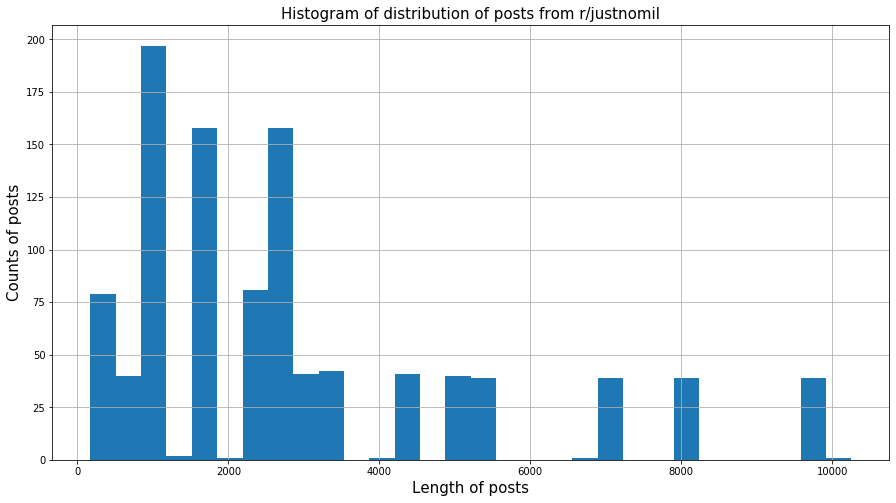

In [66]:
#distribution of length of posts for r/justnomil
plt.figure(figsize = (15,8))
plt.grid()
plt.hist([len(x) for x in jnm['posts']], bins = 30)
plt.ylabel('Counts of posts', size=15)
plt.xlabel('Length of posts', size=15)
plt.title('Histogram of distribution of posts from r/justnomil', size = 15)

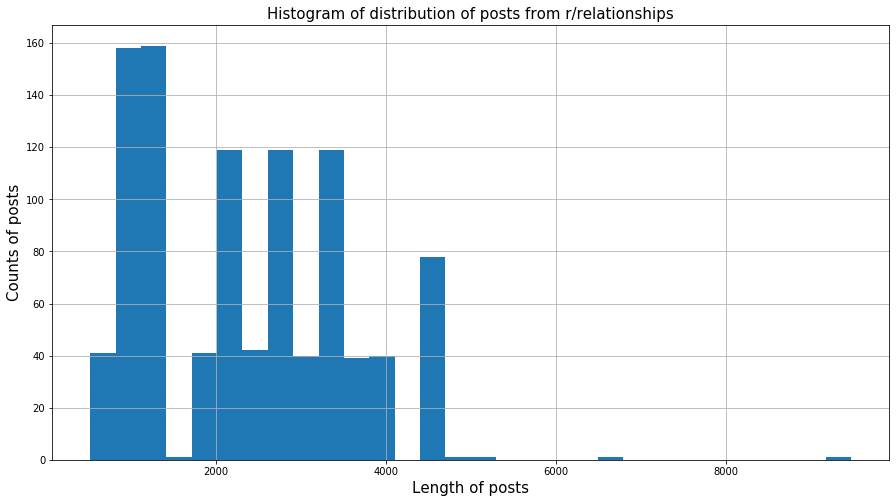

In [67]:
#distribution of posts from r/relationships
plt.figure(figsize = (15,8))
plt.hist([len(x) for x in rships['posts']], bins = 30)
plt.ylabel('Counts of posts', size=15)
plt.xlabel('Length of posts', size=15)
plt.title('Histogram of distribution of posts from r/relationships', size = 15)
plt.grid()

In [68]:
#finding out how many posts were taken from each subreddit
print(len(rships), len(jnm))

1000 1039


In [69]:
#checking if anything were duplicate entries
print(len(rships.duplicated(keep='first'))) #no change in resulting length
print(len(jnm.duplicated(keep='first'))) #no change in resulting length

1000
1039


### Combining the dataframes together

In [70]:
# appending the dataframes together
combined = rships.append(jnm)

In [71]:
#reseting the index to prevent duplicated index numbers
combined = combined.reset_index(drop = True)

In [72]:
combined.tail()

,posts,subreddit
2034,"This weekend was my gf (F, 31) and my (F,24) 5...",1
2035,I just had my third child (second with DH) abo...,1
2036,Old story so no advice wanted for this specifi...,1
2037,I have made this into bullet points so I can c...,1
2038,"I am transgender, female to male, I've been ou...",1


In [73]:
combined.shape

(2039, 2)

### Cleaning of text into clean text without punctuations and stopwords

In [74]:
#importing of stopwords
stopwords = stopwords.words('english')

In [75]:
def clean(text):
    # Function to convert a raw review to a string of words
   
    # 1. Remove HTML.
    new_text = BeautifulSoup(text).get_text()
    
    # 2. Remove non-letters.
    no_links = re.sub("\(https\S+\)", " ", new_text)
    letters_only = re.sub("[^a-zA-Z]", " ", no_links)
    
    # 3. Convert to lower case, split into individual words.
    words = letters_only.lower().split()
    
    # 4. Initiate Porterstemmer and stem the text
    p_s = PorterStemmer()
    stemmed = [p_s.stem(x) for x in words]
    
    # 5. In Python, searching a set is much faster than searching
    # a list, so convert the stop words to a set.
    stops = set(stopwords)
    
    # 6. Remove stop words.
    meaningful_words = [w for w in stemmed if not w in stopwords]
    
    # 7. Join the words back into one string separated by space, 
    # and return the result.
    return(" ".join(meaningful_words))

In [76]:
#visual inspection
combined['posts'][981]

"Original post [here](https://old.reddit.com/r/relationships/comments/d9xc55/i_24f_have_a_crush_on_a_guy_29m_at_my_grad_school/).\n\nThanks for all your advice (except for everyone who gave me abuse or told me to just fuck the guy I had a crush on)! I was worried the crush would stay, most people in the comments said it would go away, and I guess you were right.\n\nI talked to my fiancé about it and when we were talking we realized I've been staying at school to study every evening and haven't been making much time for him. I leave school before 6pm now so I get home when he does after he's been to work and we're spending quality time together every day, which is making us closer and helping me remember all the great things that our relationship has.\n\nI also talked to Will (a lot of you suggested that if I got to know him the crush would go away). I didn't tell him about the crush. I just made a friend. We're...very different. It would never work. I basically had 3 conversations with

In [77]:
combined['posts'] = [clean(x) for x in combined['posts']]

In [78]:
#visual inspection of post after cleaning
combined['posts'][981]

'origin post thank advic except everyon gave abus told fuck guy crush wa worri crush would stay peopl comment said would go away guess right talk fianc talk realiz stay school studi everi even make much time leav school befor pm get home doe work spend qualiti time togeth everi day make us closer help rememb great thing relationship ha also talk lot suggest got know crush would go away tell crush made friend veri differ would never work basic convers crush die fun gaze even togeth singl turn engag well go figur feel anymor tl dr chri'

### Wordcloud of frequency of words present in the posts

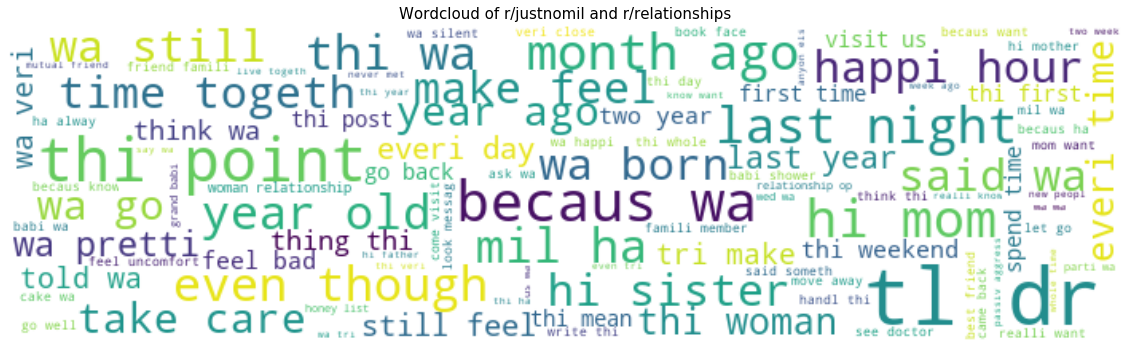

In [79]:
text = " ".join(e for e in combined['posts'])

wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white", width=700).generate(text)
# Save image file 
wordcloud.to_file("./bag_of_words.png")

# Display the generated image:
plt.figure(figsize = (20,20))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title('Wordcloud of r/justnomil and r/relationships', size = 15)
plt.show()

### Analysis of words

The data is split into training and test sets so a model could be created to predict if a post is either from r/relationships or r/justnomil

In [80]:
# making train test split of data
X_train, X_test, y_train, y_test = train_test_split(combined['posts'],
                                                    combined['subreddit'],
                                                    stratify= combined['subreddit'],
                                                    random_state = 42)

In [81]:
#shape of the series
X_train.shape

(1529,)

### Vectorizing the posts to the top 2000 words

A pipeline was created so that the Count Vectorizer can be test for the different parameters

In [116]:
#CountVectorizer was initialised
cvec = CountVectorizer()

In [117]:
# Pipeline was created
pipe = Pipeline([
    ('cvec', CountVectorizer()),
    ('lr', LogisticRegression())
                ])

In [118]:
# the parameters to be tested by the pipeline 
param = {'cvec__max_features': [2000, 2500, 3000, 3500],\
    'cvec__min_df': [2, 3],
    'cvec__max_df': [.9, .95],
    'cvec__ngram_range': [(1,1), (1,2)]}

In [119]:
#gridsearch was initialised and the training set was fitted into it
grid = GridSearchCV(pipe, param_grid=param, cv = 5, verbose = 1)
grid.fit(X_train, y_train)

Fitting 5 folds for each of 32 candidates, totalling 160 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/ongzhongliang/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
[Parallel(n_jobs=1)]: Done 160 out of 160 | elapsed:  3.0min finished


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('cvec', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip...penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False))]),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'cvec__max_features': [2000, 2500, 3000, 3500], 'cvec__min_df': [2, 3], 'cvec__max_df': [0.9, 0.95], 'cvec__ngram_range': [(1, 1), (1, 2)]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=1)

In [120]:
#the parameters that gave the best score
grid.best_params_

{'cvec__max_df': 0.9,
 'cvec__max_features': 2500,
 'cvec__min_df': 2,
 'cvec__ngram_range': (1, 2)}

In [121]:
grid.best_score_

0.9960758665794637

In [122]:
# using the same parameters, the score was generated for the test datasets
grid.score(X_test, y_test)

0.9941176470588236

In [123]:
# countvectorizer was initialised with the parameters that was found using gridsearch
cvec = CountVectorizer(max_df = 0.9, max_features = 2500, min_df = 2, ngram_range=(1,2))

In [124]:
#X_train data fit graph and the words were vectorised into different columns
X_train_cvec = pd.DataFrame(cvec.fit_transform(X_train).toarray(),columns = cvec.get_feature_names()) 

In [125]:
#list of words vectorised
cvec_col = cvec.get_feature_names()

In [126]:
print(X_train_cvec.shape)

(1529, 2500)


In [127]:
#X_test words were vectorised into different columns
X_test_cvec = pd.DataFrame(cvec.transform(X_test).toarray(), columns = cvec.get_feature_names()) #transform the X_test data

### Logistic Regression was performed (Count Vectorized)

In [128]:
# logistic regression initialised
lr = LogisticRegression()

In [129]:
# X_train data fitted
modellr = lr.fit(X_train_cvec, y_train)

In [130]:
#score for model was found
scorelr = lr.score(X_test_cvec, y_test)

In [131]:
scorelr

0.9941176470588236

In [132]:
#words and their coefficients in the logistic regression model were placed into a dataframe
colcoef = pd.DataFrame()
colcoef['words'] = [x for x in X_test_cvec.columns]
colcoef['coeff'] = [y for y in lr.coef_[0]]

In [133]:
#top 10 words that indicate positive relationship to being a r/justnomil post
colcoef.sort_values(by = 'coeff', ascending = False).head(10)

,words,coeff
1324,mil,0.715748
1618,post,0.592799
516,dh,0.517347
624,entir,0.371544
842,go,0.316553
2284,vent,0.303665
1362,moment,0.290821
179,bec,0.289464
548,doe,0.285433
1194,like make,0.285282


In [134]:
#top 10 words that indicate positive relationship to being a r/relationships post
colcoef.sort_values(by = 'coeff', ascending = False).tail(10)

,words,coeff
1966,stay,-0.253736
1246,lot,-0.267016
810,get,-0.283022
2084,thi,-0.283785
1706,realli,-0.287860
777,friend,-0.297468
1564,peopl,-0.307550
561,dr,-0.517861
2188,tl dr,-0.517861
2187,tl,-0.517861


### Naive Bayes Method

Multinomial Naive Bayes method was chosen due to the non-binary values of each column.

In [173]:
# initialising Multinomial Naive Bayes
nb = MultinomialNB(class_prior = [.5, .5]) #prior probability

In [174]:
# Fit our model!
modelnb = nb.fit(X_train_cvec, y_train)

In [175]:
predictions = modelnb.predict(X_test_cvec)

In [176]:
scorenb_train = modelnb.score(X_train_cvec, y_train)
scorenb_train

0.9973839110529757

In [177]:
scorenb_test = modelnb.score(X_test_cvec, y_test)
scorenb_test

0.9941176470588236

In [178]:
confusion_matrix(y_test, predictions)

array([[249,   1],
       [  2, 258]])

In [179]:
tn, fp, fn, tp = confusion_matrix(y_test, predictions).ravel()

In [180]:
print("True Negatives: %s" % tn)
print("False Positives: %s" % fp)
print("False Negatives: %s" % fn)
print("True Positives: %s" % tp)

True Negatives: 249
False Positives: 1
False Negatives: 2
True Positives: 258


In [181]:
nbcolcoef = pd.DataFrame()
nbcolcoef['words'] = [x for x in X_test_cvec.columns]
nbcolcoef['coeff'] = [y for y in nb.coef_[0]]

In [182]:
#top 10 words that indicate positive relationship to being a r/justnomil post
nbcolcoef.sort_values(by = 'coeff', ascending = False).head(10)

,words,coeff
2296,wa,-3.809090
2084,thi,-4.443385
1324,mil,-4.462620
180,becaus,-4.533219
968,hi,-4.698121
842,go,-4.710730
1185,like,-4.758715
2360,want,-4.825954
910,ha,-4.846425
810,get,-4.929734


In [183]:
#top 10 words that indicate positive relationship to being a r/relationships post
nbcolcoef.sort_values(by = 'coeff', ascending = False).tail(10)

,words,coeff
1151,later option,-12.335837
630,especi sinc,-12.335837
2020,sunday,-12.335837
2021,sunday clean,-12.335837
1155,laundri dish,-12.335837
2027,sure side,-12.335837
954,hear nice,-12.335837
64,amount money,-12.335837
2032,swear,-12.335837
705,fear water,-12.335837


In [112]:
## TFDIF

In [195]:
# Pipeline was created
pipe1 = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('lr', LogisticRegression())
                ])

In [196]:
# the parameters to be tested by the pipeline 
param2 = {'tvec__max_features': [2000, 2500, 3000, 3500],\
    'tvec__min_df': [2, 3],
    'tvec__max_df': [.9, .95],
    'tvec__ngram_range': [(1,1), (1,2), (1,3)]}

In [198]:
#gridsearch was initialised and the training set was fitted into it
grid2 = GridSearchCV(pipe1, param_grid=param2, cv = 5, verbose = 1)
grid2.fit(X_train, y_train)

Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/ongzhongliang/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
[Parallel(n_jobs=1)]: Done 240 out of 240 | elapsed:  5.9min finished


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('tvec', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
...penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False))]),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'tvec__max_features': [2000, 2500, 3000, 3500], 'tvec__min_df': [2, 3], 'tvec__max_df': [0.9, 0.95], 'tvec__ngram_range': [(1, 1), (1, 2), (1, 3)]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=1)

In [199]:
#the parameters that gave the best score
grid2.best_params_

{'tvec__max_df': 0.9,
 'tvec__max_features': 2500,
 'tvec__min_df': 2,
 'tvec__ngram_range': (1, 2)}

In [200]:
grid2.best_score_

0.9967298888162197

In [201]:
# using the same parameters, the score was generated for the test datasets
grid2.score(X_test, y_test)

0.9941176470588236

In [202]:
# countvectorizer was initialised with the parameters that was found using gridsearch
tvec = TfidfVectorizer(max_df = 0.9, max_features = 2500, min_df = 2, ngram_range=(1,2))

In [203]:
#X_train data fit graph and the words were vectorised into different columns
X_train_tvec = pd.DataFrame(tvec.fit_transform(X_train).toarray(),columns = tvec.get_feature_names()) 

In [204]:
#list of words vectorised
tvec_col = tvec.get_feature_names()

In [205]:
print(X_train_tvec.shape)

(1529, 2500)


In [206]:
#X_test words were vectorised into different columns
X_test_tvec = pd.DataFrame(cvec.transform(X_test).toarray(), columns = tvec.get_feature_names()) #transform the X_test data

### Logistic Regression was performed

In [207]:
# logistic regression initialised
lrt = LogisticRegression()

In [208]:
# X_train data fitted
modellrt = lrt.fit(X_train_tvec, y_train)

In [209]:
#score for model was found
scorelrt = lrt.score(X_test_tvec, y_test)

In [210]:
scorelrt

0.9921568627450981

In [1]:
#words and their coefficients in the logistic regression model were placed into a dataframe
colcoeft = pd.DataFrame()
colcoeft['words'] = [x for x in X_test_tvec.columns]
colcoeft['coeff'] = [y for y in lrt.coef_[0]]

NameError: name 'pd' is not defined

In [212]:
#top 10 words that indicate positive relationship to being a r/justnomil post
colcoeft.sort_values(by = 'coeff', ascending = False).head(10)

,words,coeff
1324,mil,4.337510
516,dh,3.136572
968,hi,1.684337
151,babi,1.579972
2386,wed,1.503067
2440,woman,1.397670
1222,lo,1.348422
2393,weekend,1.290979
842,go,1.279219
1977,stepmum,1.272874


In [213]:
#top 10 words that indicate positive relationship to being a r/relationships post
colcoeft.sort_values(by = 'coeff', ascending = False).tail(10)

,words,coeff
2084,thi,-1.202128
457,crush,-1.295017
1706,realli,-1.315370
1688,raft,-1.329624
1966,stay,-1.355570
2188,tl dr,-1.428140
2187,tl,-1.428140
561,dr,-1.428140
1736,relationship,-1.438684
369,class,-1.464814


### Naive Bayes Method

In [214]:
# initialising Multinomial Naive Bayes
nbt = MultinomialNB()

In [215]:
# Fit our model!
modelnbt = nbt.fit(X_train_tvec, y_train)

In [216]:
predictionst = modelnbt.predict(X_test_tvec)

In [217]:
scorenbt_train = modelnbt.score(X_train_tvec, y_train)
scorenbt_train

0.9960758665794637

In [218]:
scorenbt_test = modelnbt.score(X_test_tvec, y_test)
scorenbt_test

0.996078431372549

In [219]:
confusion_matrix(y_test, predictionst)

array([[250,   0],
       [  2, 258]])

In [220]:
tn, fp, fn, tp = confusion_matrix(y_test, predictionst).ravel()

In [221]:
print("True Negatives: %s" % tn)
print("False Positives: %s" % fp)
print("False Negatives: %s" % fn)
print("True Positives: %s" % tp)

True Negatives: 250
False Positives: 0
False Negatives: 2
True Positives: 258


In [222]:
nbtcolcoef = pd.DataFrame()
nbtcolcoef['words'] = [x for x in X_test_tvec.columns]
nbtcolcoef['coeff'] = [y for y in nbt.coef_[0]]

In [223]:
#top 10 words that indicate positive relationship to being a r/justnomil post
nbtcolcoef.sort_values(by = 'coeff', ascending = False).head(10)

,words,coeff
1324,mil,-5.013554
2296,wa,-5.054311
968,hi,-5.377346
516,dh,-5.379222
842,go,-5.526427
180,becaus,-5.556966
2084,thi,-5.605192
910,ha,-5.729380
2360,want,-5.729724
1185,like,-5.769768


In [224]:
#top 10 words that indicate positive relationship to being a r/relationships post
nbtcolcoef.sort_values(by = 'coeff', ascending = False).tail(10)

,words,coeff
1685,quietli,-9.257205
1686,quietli said,-9.257205
1688,raft,-9.257205
1690,randomli,-9.257205
1693,rather relationship,-9.257205
117,arrang natur,-9.257205
1699,readi sleep,-9.257205
1705,realiz retrospect,-9.257205
1707,realli felt,-9.257205
156,bachelor parti,-9.257205
